torch.Size([128, 128])
W_frozen shape: torch.Size([128, 128])
A shape       : torch.Size([32, 128])
B shape       : torch.Size([128, 32])
LoRA trainable params: 8,192
Full-FT params      : 16,384


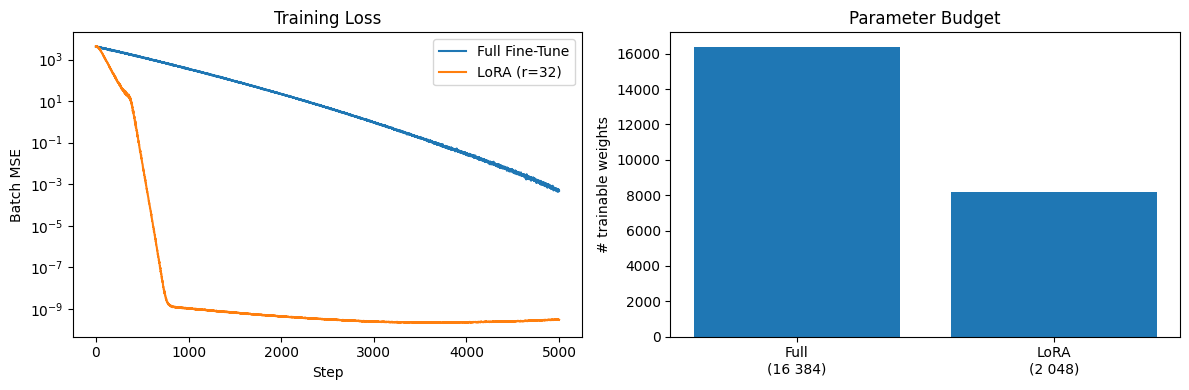

ΔW MSE  LoRA : 1.18e-12
ΔW MSE  Full : 3.81e-06


In [ ]:

import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
torch.manual_seed(42)

# 1) Synthetic task -------------------------------------------------
k, d, r = 128, 128, 32 # k is output , d is input , and r is rank

W_base  = torch.randn(k, d)                 # "pre-trained" frozen weight
A_true  = torch.randn(r, d)
B_true  = torch.randn(k, r)
W_true  = W_base + B_true @ A_true          # ground-truth weight

#print(W_base.shape) # 128 x 128
#print(A_true.shape) # 32 x 128
#print(B_true.shape) # 128 x 32
#print(W_true.shape) # 128 x 128

N = 10_000
X = torch.randn(N, d)
y = X @ W_true.t() # 10,000 x 128
print(W_true.t().shape) # 128 x 128
#print(y.shape) # 10,000 x 128  output of the model


# 2) Models ---------------------------------------------------------
class LoRALinear(nn.Module):
    def __init__(self, W_frozen, rank):
        super().__init__()
        k, d = W_frozen.shape # 128 x 128 it is from W_base, k is output d is input
        self.register_buffer("W", W_frozen)
        self.A = nn.Parameter(0.01 * torch.randn(rank, d)) # 32 x 128
        self.B = nn.Parameter(torch.zeros(k, rank)) # 128 x 32
        print(f"W_frozen shape: {W_frozen.shape}")  # [k, d]
        print(f"A shape       : {self.A.shape}")     # [r, d]
        print(f"B shape       : {self.B.shape}")     # [k, r]

    def forward(self, x):
        return x @ (self.W + self.B @ self.A).t()

class FullLinear(nn.Module):
    def __init__(self, W_init):
        super().__init__()
        self.W = nn.Parameter(W_init.clone())

    def forward(self, x):
        return x @ self.W.t()

model_lora = LoRALinear(W_base, r)
model_full = FullLinear(W_base)

print(f"LoRA trainable params: {sum(p.numel() for p in model_lora.parameters() if p.requires_grad):,}")
print(f"Full-FT params      : {sum(p.numel() for p in model_full.parameters() if p.requires_grad):,}")

# 3) Training -------------------------------------------------------
def train(model, steps=5000, batch=256, lr=1e-2):
    opt = optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    losses = []
    for s in range(steps):
        idx = torch.randint(0, N, (batch,)) #256
        loss = mse(model(X[idx]), y[idx])
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return losses

loss_lora = train(model_lora)
loss_full = train(model_full)

# 4) Plots ----------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].plot(loss_full, label="Full Fine-Tune")
ax[0].plot(loss_lora, label=f"LoRA (r={r})")
ax[0].set_yscale("log"); ax[0].set_xlabel("Step"); ax[0].set_ylabel("Batch MSE")
ax[0].set_title("Training Loss"); ax[0].legend()

ax[1].bar(["Full\n(16 384)", "LoRA\n(2 048)"],
          [16_384, r*(k+d)])
ax[1].set_ylabel("# trainable weights")
ax[1].set_title("Parameter Budget")

plt.tight_layout(); plt.show()

# 5) How close to the true ΔW? -------------------------------------
with torch.no_grad():
    ΔW_true = B_true @ A_true
    ΔW_lora = model_lora.B @ model_lora.A
    ΔW_full = model_full.W - W_base
    mse = lambda a,b: ((a-b)**2).mean().item()
    print(f"ΔW MSE  LoRA : {mse(ΔW_lora, ΔW_true):.2e}")
    print(f"ΔW MSE  Full : {mse(ΔW_full , ΔW_true):.2e}")
